# 07. Experiment Tracking

Reference Video: https://www.udemy.com/course/pytorch-for-deep-learning/learn/lecture/33022814#overview

Reference Book: https://www.learnpytorch.io/07_pytorch_experiment_tracking/

Extra curricular Reference: [Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html)

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary
from going_modular import data_setup, engine, utils

/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [4]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


### Load the dataset (10% of Food101)

In [5]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Create data loaders

In [6]:
from torchvision import datasets, transforms
import os

##########
# OLD - manually create transforms

# # Values are from ImageNet
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])

# # Create simple transform
# data_transform = transforms.Compose([ 
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     normalize
# ])

#############

#############
# NEW - pytorch automatically selects the transform based on the pre-trained model
# Basically tranform the same way as the pretrained model was trained

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # defaults to imagenet IMAGENET1K_V1

auto_transform = weights.transforms() # returns a transform.Compose object
print(f'auto_transform: {auto_transform}')

auto_transform: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [7]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                              test_dir=test_dir,
                              transform=auto_transform,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

print(f"train_dataloader: {train_dataloader}")
print(f"test_dataloader: {test_dataloader}")
print(f"class_names: {class_names}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fa13b950790>
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fa2394ee750>
class_names: ['pizza', 'steak', 'sushi']


### Setting up pretrained model

We are using EfficientNet B0 model

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential: 2-2  

### Transfer learning - Freeze all layers except the last one

In [10]:
for params in model.features.parameters(): # we want to freeze entire feature extractor
    params.requires_grad = False

In [11]:
# Check the classifier for reference
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [12]:
# Update the classifier head 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names)),
).to(device)

In [13]:
# Check the classifier for reference
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [14]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

### Train model

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

### Initialize Tensorboard

In [17]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer

In [18]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from going_modular.engine import train_step, test_step

set_seeds(seed=42)

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: SummaryWriter) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
  }
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      
      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      ### New: tensorboard logging ###

      if writer:
          writer.add_scalars(main_tag="Loss",
                             tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                             global_step=epoch)
          
          writer.add_scalars(main_tag="Accuracy",
                             tag_scalar_dict={"train_acc": train_acc,
                                              "test_acc": test_acc},
                             global_step=epoch)
          
          writer.add_graph(model=model,
                           input_to_model=torch.rand(1, 3, 224, 224).to(device))
          
          writer.close()

      else:
          pass
  
  ### End: tensorboard logging ###

  # Return the filled results at the end of the epochs
  return results

In [19]:
from torch.utils.tensorboard import SummaryWriter

def create_write(experiment_name: str,
                 model_name: str,
                 extra: str=None):
    
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    if extra:
        los_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        los_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter directory: {los_dir}")

    return SummaryWriter(log_dir=los_dir)

In [ ]:
example_writer = create_write(experiment_name="data_10_perc",
                              model_name="efficientnet_b0",
                              extra="epoch_5")

In [ ]:
NUM_EPOCHS = 5

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device,
                writer=example_writer)

In [ ]:
NUM_EPOCHS = [5, 10]

for epoch in NUM_EPOCHS:
    example_writer = create_write(experiment_name="mini_food",
                              model_name="efficientnet_b0",
                              extra="epoch_{}".format(epoch))
    results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epoch,
                device=device,
                writer=example_writer)

### Experiment tracking

1. Dataset 10% vs 20%
2. EfficientNet B0 vs EfficientNet B2
3. Epoch 5 vs 10


In [20]:
from helper_functions import download_data

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


### Testdata loader - 20%

In [21]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path_20 = data_path / "pizza_steak_sushi_20_percent"

# Setup train and testing paths
train_dir_20 = image_path_20 / "train"

# NOTE: we are KEEPING same TEST SET

from torchvision import datasets, transforms
import os

#############
# NEW - pytorch automatically selects the transform based on the pre-trained model
# Basically tranform the same way as the pretrained model was trained

weights_b0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT # defaults to imagenet IMAGENET1K_V1

auto_transform_b0 = weights_b0.transforms() # returns a transform.Compose object
print(f'auto_transform B0: {auto_transform_b0}')


NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader_20, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20,
                    test_dir=test_dir,
                    transform=auto_transform_b0,
                    batch_size=BATCH_SIZE,
                    num_workers=NUM_WORKERS)

print(f"train_dataloader: {train_dataloader_20}")
print(f"test_dataloader: {test_dataloader}")
print(f"class_names: {class_names}")


auto_transform B0: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi_20_percent/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
train_dataloader: <torch.utils.data.dataloade

### Models

In [22]:
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_b2 = torchvision.models.efficientnet_b2(weights=weights_b2)

for params in model_b2.features.parameters(): # we want to freeze entire feature extractor
    params.requires_grad = False

# Update the classifier head 
model_b2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408, out_features=len(class_names)),
).to(device)

# EfficientNet B2
summary(model=model_b2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1408, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

In [23]:
# EfficientNet B0
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

### Create experiments

In [24]:
num_epochs = [5, 10]

models = ['efficientnet_b0', 'efficientnet_b2']

train_dataloaders = {'data_10_perc': train_dataloader,
                     'data_20_percent': train_dataloader_20,
                    }

In [25]:
from going_modular.utils import save_model

set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataload in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            experiment_number += 1
            print(f"[INFO] Experiment Number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] Epochs: {epochs}")
            print(f"[INFO] Dataloader: {dataloader_name}")

            if model_name == 'efficientnet_b0':
                model = model
            else:
                model = model_b2

            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

            train(model=model,
                  train_dataloader=train_dataload,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_write(experiment_name=dataloader_name,
                                      model_name=model_name,
                                      extra=f"epoch_{epochs}"))
            
            # Save the model
            save_filename = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filename)
            
            print(f"-"*50 + "\n")


[INFO] Experiment Number: 1
[INFO] Model: efficientnet_b0
[INFO] Epochs: 5
[INFO] Dataloader: data_10_perc
[INFO] Created SummaryWriter directory: runs/2023-09-20_14-47-16/data_10_perc/efficientnet_b0/epoch_5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0969 | train_acc: 0.3750 | test_loss: 0.8950 | test_acc: 0.6818


 20%|██        | 1/5 [00:04<00:16,  4.06s/it]

Epoch: 2 | train_loss: 0.8932 | train_acc: 0.6641 | test_loss: 0.8175 | test_acc: 0.6828


 40%|████      | 2/5 [00:07<00:11,  3.84s/it]

Epoch: 3 | train_loss: 0.7858 | train_acc: 0.7617 | test_loss: 0.6539 | test_acc: 0.8759


 60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

Epoch: 4 | train_loss: 0.7225 | train_acc: 0.7461 | test_loss: 0.6479 | test_acc: 0.8456


 80%|████████  | 4/5 [00:15<00:03,  3.85s/it]

Epoch: 5 | train_loss: 0.6525 | train_acc: 0.7773 | test_loss: 0.6299 | test_acc: 0.8049


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


[INFO] Saving model to: models/07_efficientnet_b0_data_10_perc_5_epochs.pth
--------------------------------------------------

[INFO] Experiment Number: 2
[INFO] Model: efficientnet_b2
[INFO] Epochs: 5
[INFO] Dataloader: data_10_perc
[INFO] Created SummaryWriter directory: runs/2023-09-20_14-47-35/data_10_perc/efficientnet_b2/epoch_5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0271 | train_acc: 0.4453 | test_loss: 0.9553 | test_acc: 0.6411


 20%|██        | 1/5 [00:04<00:17,  4.40s/it]

Epoch: 2 | train_loss: 0.9186 | train_acc: 0.6484 | test_loss: 0.8011 | test_acc: 0.8447


 40%|████      | 2/5 [00:08<00:13,  4.37s/it]

Epoch: 3 | train_loss: 0.7445 | train_acc: 0.7695 | test_loss: 0.7572 | test_acc: 0.9271


 60%|██████    | 3/5 [00:13<00:08,  4.49s/it]

Epoch: 4 | train_loss: 0.7062 | train_acc: 0.7734 | test_loss: 0.6866 | test_acc: 0.8864


 80%|████████  | 4/5 [00:18<00:04,  4.60s/it]

Epoch: 5 | train_loss: 0.6012 | train_acc: 0.9141 | test_loss: 0.6610 | test_acc: 0.9375


100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


[INFO] Saving model to: models/07_efficientnet_b2_data_10_perc_5_epochs.pth
--------------------------------------------------

[INFO] Experiment Number: 3
[INFO] Model: efficientnet_b0
[INFO] Epochs: 10
[INFO] Dataloader: data_10_perc
[INFO] Created SummaryWriter directory: runs/2023-09-20_14-47-58/data_10_perc/efficientnet_b0/epoch_10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5827 | train_acc: 0.7969 | test_loss: 0.6036 | test_acc: 0.8864


 10%|█         | 1/10 [00:04<00:44,  4.89s/it]

Epoch: 2 | train_loss: 0.4594 | train_acc: 0.9570 | test_loss: 0.5861 | test_acc: 0.8864


 20%|██        | 2/10 [00:09<00:39,  4.91s/it]

Epoch: 3 | train_loss: 0.5106 | train_acc: 0.7891 | test_loss: 0.5818 | test_acc: 0.9271


 30%|███       | 3/10 [00:14<00:35,  5.03s/it]

Epoch: 4 | train_loss: 0.4783 | train_acc: 0.8008 | test_loss: 0.5037 | test_acc: 0.8864


 40%|████      | 4/10 [00:20<00:30,  5.02s/it]

Epoch: 5 | train_loss: 0.4777 | train_acc: 0.8242 | test_loss: 0.5050 | test_acc: 0.9167


 50%|█████     | 5/10 [00:25<00:25,  5.02s/it]

Epoch: 6 | train_loss: 0.4449 | train_acc: 0.8203 | test_loss: 0.5083 | test_acc: 0.8968


 60%|██████    | 6/10 [00:30<00:20,  5.06s/it]

Epoch: 7 | train_loss: 0.3995 | train_acc: 0.8555 | test_loss: 0.4743 | test_acc: 0.9375


 70%|███████   | 7/10 [00:35<00:15,  5.12s/it]

Epoch: 8 | train_loss: 0.3741 | train_acc: 0.9453 | test_loss: 0.4822 | test_acc: 0.8864


 80%|████████  | 8/10 [00:40<00:10,  5.20s/it]

Epoch: 9 | train_loss: 0.3632 | train_acc: 0.9336 | test_loss: 0.4882 | test_acc: 0.9176


 90%|█████████ | 9/10 [00:46<00:05,  5.32s/it]

Epoch: 10 | train_loss: 0.4829 | train_acc: 0.8164 | test_loss: 0.4579 | test_acc: 0.8968


100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


[INFO] Saving model to: models/07_efficientnet_b0_data_10_perc_10_epochs.pth
--------------------------------------------------

[INFO] Experiment Number: 4
[INFO] Model: efficientnet_b2
[INFO] Epochs: 10
[INFO] Dataloader: data_10_perc
[INFO] Created SummaryWriter directory: runs/2023-09-20_14-48-50/data_10_perc/efficientnet_b2/epoch_10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3527 | train_acc: 0.8477 | test_loss: 0.4373 | test_acc: 0.9072


 10%|█         | 1/10 [00:05<00:51,  5.74s/it]

Epoch: 2 | train_loss: 0.4382 | train_acc: 0.8125 | test_loss: 0.4110 | test_acc: 0.9176


 20%|██        | 2/10 [00:11<00:45,  5.68s/it]

Epoch: 3 | train_loss: 0.3249 | train_acc: 0.9727 | test_loss: 0.3959 | test_acc: 0.9375


 30%|███       | 3/10 [00:17<00:40,  5.72s/it]

Epoch: 4 | train_loss: 0.3204 | train_acc: 0.8438 | test_loss: 0.3852 | test_acc: 0.9271


 40%|████      | 4/10 [00:22<00:34,  5.77s/it]

Epoch: 5 | train_loss: 0.3209 | train_acc: 0.8477 | test_loss: 0.4125 | test_acc: 0.8968


 50%|█████     | 5/10 [00:28<00:28,  5.78s/it]

Epoch: 6 | train_loss: 0.3656 | train_acc: 0.8516 | test_loss: 0.3848 | test_acc: 0.9375


 60%|██████    | 6/10 [00:34<00:23,  5.85s/it]

Epoch: 7 | train_loss: 0.2707 | train_acc: 0.9883 | test_loss: 0.3805 | test_acc: 0.9271


 70%|███████   | 7/10 [00:40<00:17,  5.93s/it]

Epoch: 8 | train_loss: 0.2708 | train_acc: 0.9648 | test_loss: 0.3985 | test_acc: 0.9375


 80%|████████  | 8/10 [00:47<00:12,  6.00s/it]

Epoch: 9 | train_loss: 0.4365 | train_acc: 0.8008 | test_loss: 0.4256 | test_acc: 0.9072


 90%|█████████ | 9/10 [00:53<00:06,  6.04s/it]

Epoch: 10 | train_loss: 0.3353 | train_acc: 0.8438 | test_loss: 0.3561 | test_acc: 0.9072


100%|██████████| 10/10 [00:59<00:00,  5.92s/it]


[INFO] Saving model to: models/07_efficientnet_b2_data_10_perc_10_epochs.pth
--------------------------------------------------

[INFO] Experiment Number: 5
[INFO] Model: efficientnet_b0
[INFO] Epochs: 5
[INFO] Dataloader: data_20_percent
[INFO] Created SummaryWriter directory: runs/2023-09-20_14-49-49/data_20_percent/efficientnet_b0/epoch_5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3797 | train_acc: 0.8688 | test_loss: 0.3305 | test_acc: 0.9375


 20%|██        | 1/5 [00:06<00:27,  6.76s/it]

Epoch: 2 | train_loss: 0.3893 | train_acc: 0.8729 | test_loss: 0.3565 | test_acc: 0.9271


 40%|████      | 2/5 [00:13<00:19,  6.65s/it]

Epoch: 3 | train_loss: 0.3887 | train_acc: 0.8729 | test_loss: 0.3323 | test_acc: 0.9271


 60%|██████    | 3/5 [00:19<00:13,  6.63s/it]

Epoch: 4 | train_loss: 0.3165 | train_acc: 0.8958 | test_loss: 0.3377 | test_acc: 0.9271


 80%|████████  | 4/5 [00:26<00:06,  6.73s/it]

Epoch: 5 | train_loss: 0.2824 | train_acc: 0.9104 | test_loss: 0.3132 | test_acc: 0.9479


100%|██████████| 5/5 [00:33<00:00,  6.71s/it]


[INFO] Saving model to: models/07_efficientnet_b0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment Number: 6
[INFO] Model: efficientnet_b2
[INFO] Epochs: 5
[INFO] Dataloader: data_20_percent
[INFO] Created SummaryWriter directory: runs/2023-09-20_14-50-23/data_20_percent/efficientnet_b2/epoch_5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3219 | train_acc: 0.8917 | test_loss: 0.3312 | test_acc: 0.8968


 20%|██        | 1/5 [00:06<00:27,  7.00s/it]

Epoch: 2 | train_loss: 0.2573 | train_acc: 0.9417 | test_loss: 0.2930 | test_acc: 0.9375


 40%|████      | 2/5 [00:13<00:20,  6.91s/it]

Epoch: 3 | train_loss: 0.2066 | train_acc: 0.9458 | test_loss: 0.2944 | test_acc: 0.9072


 60%|██████    | 3/5 [00:20<00:13,  6.92s/it]

Epoch: 4 | train_loss: 0.2333 | train_acc: 0.9313 | test_loss: 0.2937 | test_acc: 0.9176


 80%|████████  | 4/5 [00:27<00:06,  6.94s/it]

Epoch: 5 | train_loss: 0.2504 | train_acc: 0.9125 | test_loss: 0.2824 | test_acc: 0.9176


100%|██████████| 5/5 [00:35<00:00,  7.04s/it]


[INFO] Saving model to: models/07_efficientnet_b2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment Number: 7
[INFO] Model: efficientnet_b0
[INFO] Epochs: 10
[INFO] Dataloader: data_20_percent
[INFO] Created SummaryWriter directory: runs/2023-09-20_14-50-58/data_20_percent/efficientnet_b0/epoch_10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2163 | train_acc: 0.9313 | test_loss: 0.2929 | test_acc: 0.9176


 10%|█         | 1/10 [00:07<01:05,  7.23s/it]

Epoch: 2 | train_loss: 0.1882 | train_acc: 0.9479 | test_loss: 0.2687 | test_acc: 0.9375


 20%|██        | 2/10 [00:14<00:58,  7.29s/it]

Epoch: 3 | train_loss: 0.2197 | train_acc: 0.9271 | test_loss: 0.2636 | test_acc: 0.9479


 30%|███       | 3/10 [00:22<00:52,  7.43s/it]

Epoch: 4 | train_loss: 0.1659 | train_acc: 0.9583 | test_loss: 0.2803 | test_acc: 0.9072


 40%|████      | 4/10 [00:29<00:44,  7.44s/it]

Epoch: 5 | train_loss: 0.2146 | train_acc: 0.9354 | test_loss: 0.2746 | test_acc: 0.9176


 50%|█████     | 5/10 [00:37<00:37,  7.46s/it]

Epoch: 6 | train_loss: 0.1951 | train_acc: 0.9146 | test_loss: 0.2632 | test_acc: 0.8968


 60%|██████    | 6/10 [00:44<00:29,  7.48s/it]

Epoch: 7 | train_loss: 0.2075 | train_acc: 0.9417 | test_loss: 0.2883 | test_acc: 0.9072


 70%|███████   | 7/10 [00:52<00:22,  7.64s/it]

Epoch: 8 | train_loss: 0.1676 | train_acc: 0.9563 | test_loss: 0.2895 | test_acc: 0.9176


 80%|████████  | 8/10 [01:00<00:15,  7.69s/it]

Epoch: 9 | train_loss: 0.1626 | train_acc: 0.9708 | test_loss: 0.2783 | test_acc: 0.9176


 90%|█████████ | 9/10 [01:08<00:07,  7.75s/it]

Epoch: 10 | train_loss: 0.2373 | train_acc: 0.8958 | test_loss: 0.2738 | test_acc: 0.9176


100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


[INFO] Saving model to: models/07_efficientnet_b0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment Number: 8
[INFO] Model: efficientnet_b2
[INFO] Epochs: 10
[INFO] Dataloader: data_20_percent
[INFO] Created SummaryWriter directory: runs/2023-09-20_14-52-15/data_20_percent/efficientnet_b2/epoch_10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1571 | train_acc: 0.9563 | test_loss: 0.2752 | test_acc: 0.9072


 10%|█         | 1/10 [00:07<01:11,  7.90s/it]

Epoch: 2 | train_loss: 0.2215 | train_acc: 0.9396 | test_loss: 0.2347 | test_acc: 0.9280


 20%|██        | 2/10 [00:15<01:04,  8.01s/it]

Epoch: 3 | train_loss: 0.2280 | train_acc: 0.9104 | test_loss: 0.2661 | test_acc: 0.9176


 30%|███       | 3/10 [00:24<00:56,  8.12s/it]

Epoch: 4 | train_loss: 0.1086 | train_acc: 0.9833 | test_loss: 0.2334 | test_acc: 0.9280


 40%|████      | 4/10 [00:32<00:49,  8.23s/it]

Epoch: 5 | train_loss: 0.2088 | train_acc: 0.9292 | test_loss: 0.2475 | test_acc: 0.9176


 50%|█████     | 5/10 [00:40<00:41,  8.26s/it]

Epoch: 6 | train_loss: 0.2252 | train_acc: 0.9542 | test_loss: 0.2773 | test_acc: 0.9072


 60%|██████    | 6/10 [00:49<00:32,  8.24s/it]

Epoch: 7 | train_loss: 0.1047 | train_acc: 0.9771 | test_loss: 0.2408 | test_acc: 0.9176


 70%|███████   | 7/10 [00:57<00:24,  8.30s/it]

Epoch: 8 | train_loss: 0.1149 | train_acc: 0.9771 | test_loss: 0.2502 | test_acc: 0.9280


 80%|████████  | 8/10 [01:06<00:16,  8.46s/it]

Epoch: 9 | train_loss: 0.1463 | train_acc: 0.9437 | test_loss: 0.2597 | test_acc: 0.9280


 90%|█████████ | 9/10 [01:14<00:08,  8.50s/it]

Epoch: 10 | train_loss: 0.1371 | train_acc: 0.9437 | test_loss: 0.2352 | test_acc: 0.9072


100%|██████████| 10/10 [01:23<00:00,  8.35s/it]

[INFO] Saving model to: models/07_efficientnet_b2_data_20_percent_10_epochs.pth
--------------------------------------------------



### Model expeimenr summary

- Best model
    - Model: efficientnet_b2
    - Epochs: 10
    - Dataloader: data_20_percent

In [27]:
# # Upload the results to TensorBoard.dev (uncomment to try it out)
# !tensorboard dev upload --logdir runs \
#     --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
#     --description "Comparing results of different model size, training data amount and training time."

# NOTE: Not working with Visual Studio Code

TensorFlow installation not found - running with reduced feature set.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

runs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) ^C
Traceback (most recent call last):
  File "/home/kpatel2s/miniconda3/envs/pytorch_practice/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
             ^^^^^^^^^^
  File "/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboar

### Model Prediction using the best model

In [31]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_img(model,
                      img_path,
                      class_names,
                      img_size,
                      transform,
                      device):
    img = Image.open(img_path)

    if transform is not None:
        img_transform = transform
    else:
        img_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    model.to(device)

    model.eval()
    
    with torch.inference_mode():
        img_tensor = img_transform(img).unsqueeze(0)
        img_tensor = img_tensor.to(device)
        prediction = model(img_tensor)

    pred_probs = torch.softmax(prediction, dim=1)
    pred_class = torch.argmax(pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[pred_class]} | Prob: {pred_probs.max():.3f}")

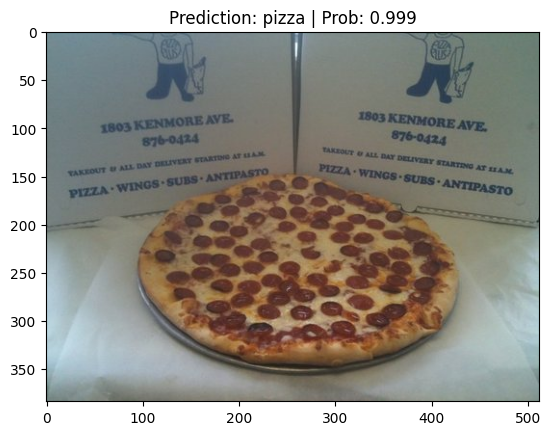

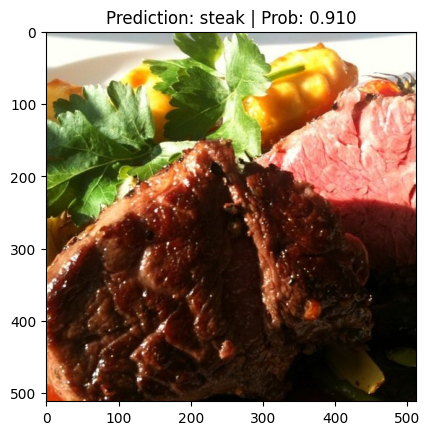

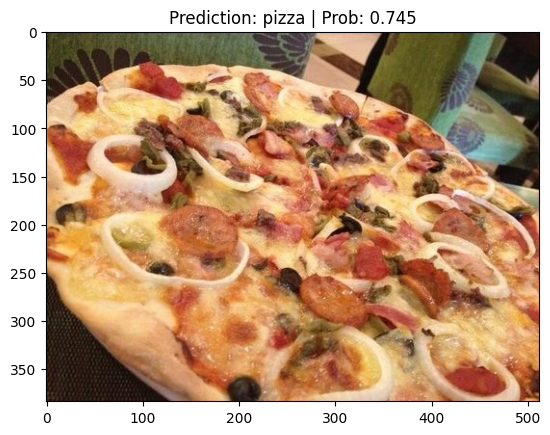

In [33]:
import random

num_imgs = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_img_path_sample = random.sample(population=test_img_path_list, k=num_imgs)

for test_img in test_img_path_sample:
    pred_and_plot_img(model=model,
                    img_path=test_img,
                    class_names=class_names,
                    img_size=(224, 224),
                    transform=auto_transform,
                    device=device)

### Benchmark on testdata

In [28]:
def evaluate_model(model,
                   dataloader,
                   device):
    
    model.eval()

    test_accuracy = 0

    for batch, (X, y) in enumerate(dataloader):
        with torch.inference_mode():
            prediction = model(X.to(device)).to(device)
            test_accuracy += ((prediction.argmax(dim=1) == y.to(device)).sum().item())

    print(f"Test accuracy: {test_accuracy/len(dataloader) * 100:.2f} %")

In [30]:
from pathlib import Path
from torchvision import datasets, transforms
from going_modular import model_builder
import torch
import matplotlib.pyplot as plt

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

test_dir = image_path / "test"

# Create simple transform
data_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                             batch_size=1,
                                             shuffle=False)

# Get class names as a list
class_names = test_data.classes

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the model architecture
model = torchvision.models.efficientnet_b2().to(device)
# Update the classifier head 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408, out_features=len(class_names)),
).to(device)

# load the model weights
weights_file = "models/07_efficientnet_b2_data_20_percent_10_epochs.pth"
model.load_state_dict(torch.load(weights_file))

evaluate_model(model=model, dataloader=test_dataloader, device=device)



Test accuracy: 96.00 %
